# Results Analysis

In [1]:
import torch
from tqdm import tqdm
from torch import nn
from pl_bolts.models.self_supervised import SwAV

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/swav_imagenet/swav_imagenet.pth.tar'
model = SwAV.load_from_checkpoint(weight_path, strict=True).model
model.prototypes=nn.Linear(128, 15)

# path to weight
model.load_state_dict(torch.load('weight/resnet50_swav_chesttot_13'))
model = model.to(device)

In [2]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose, CenterCrop, Normalize

image_size=(224, 224)
crop_dim=224
batch_size=128

test_set = ImageFolder(
    # path to dataset
    root="/home/these/DataFast/Dataset/chest_x_ray/single_label/train/",
    transform=Compose([
        Resize(image_size),
        #CenterCrop(crop_dim),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
)

In [3]:
from torch.utils.data import DataLoader

test = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

pred = []
true = []

for _, data in tqdm(enumerate(test)):
    inputs, labels = data
    inputs = inputs.to(device)
    true.append(labels.numpy())
    labels = labels.to(device)

    # forward + backward + optimize
    outputs = model(inputs)[1]
    
    pred.append(outputs.argmax(1).cpu().numpy())

574it [07:09,  1.34it/s]


In [4]:
import numpy as np
pred = np.concatenate(pred)
true = np.concatenate(true)

In [5]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(true, pred)

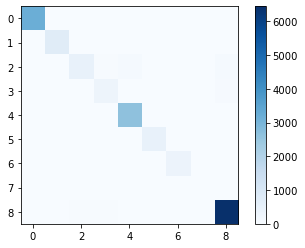

In [27]:
import matplotlib.pyplot as plt 

plt.imshow(cf[:9, :9], plt.cm.Blues)
plt.colorbar()

In [7]:
rps_classes = []
id_classes = []

for i in np.unique(true):
    rps_classes.append(100*(true==i).sum()/len(true))
    id_classes.append(i)

<BarContainer object of 15 artists>

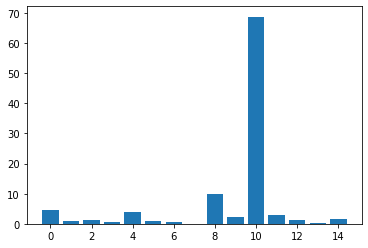

In [8]:
#ps_classes[10] = 10
plt.bar(np.arange(len(id_classes)), rps_classes)